In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# 2D Unet

reference: https://arxiv.org/pdf/1505.04597.pdf
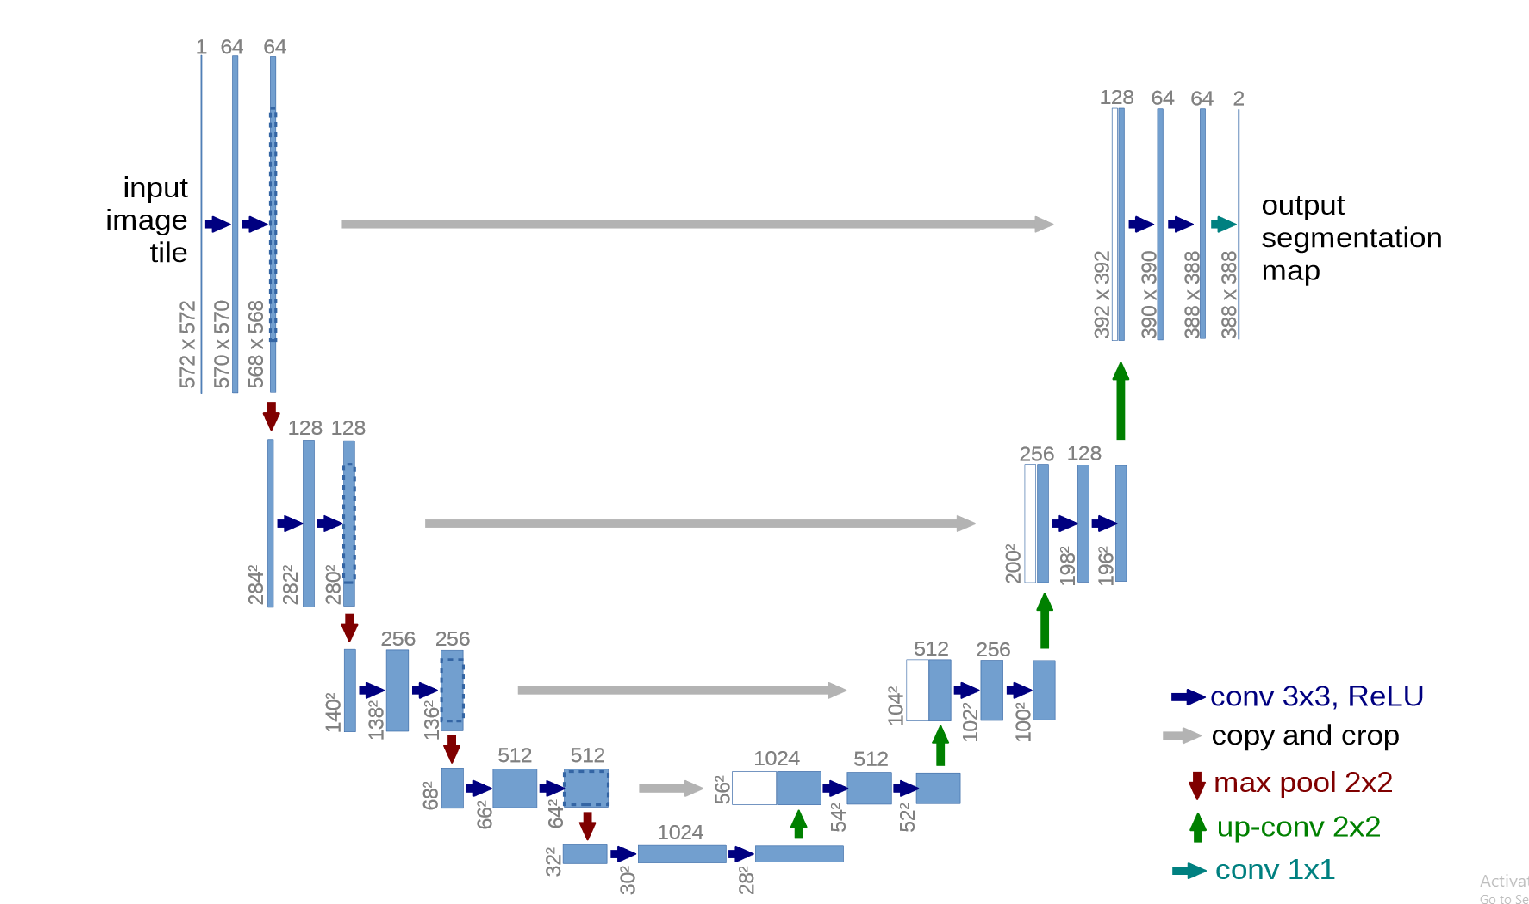

    Note: numbers need to be tuned for 512x512 images, paper uses 572x572 images

In [2]:
# convs: 3x3 unpadded, relu
# maxpooling: 2x2, stride = 2
#     double number of features after every maxpooling
# up-convolution: upsamping 2x2, followed by 2x2 convolution
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Cropping2D, Concatenate

def Unet2D(input_size = (512,512,1)):
    # Contracting Path
    inputs = Input(input_size)
    conv_1 = Conv2D(64,(3,3), activation='relu', padding='same')(inputs)
    conv_1 = Conv2D(64,(3,3), activation='relu', padding='same')(conv_1)
    maxP_1 = MaxPool2D(pool_size=(2,2), strides=2)(conv_1)

    conv_2 = Conv2D(128,(3,3), activation='relu', padding='same')(maxP_1)
    conv_2 = Conv2D(128,(3,3), activation='relu', padding='same')(conv_2)
    maxP_2 = MaxPool2D(pool_size=(2,2), strides=2)(conv_2)

    conv_3 = Conv2D(256,(3,3), activation='relu', padding='same')(maxP_2)
    conv_3 = Conv2D(256,(3,3), activation='relu', padding='same')(conv_3)
    maxP_3 = MaxPool2D(pool_size=(2,2), strides=2)(conv_3)

    conv_4 = Conv2D(512,(3,3), activation='relu', padding='same')(maxP_3)
    conv_4 = Conv2D(512,(3,3), activation='relu', padding='same')(conv_4)
    maxP_4 = MaxPool2D(pool_size=(2,2), strides=2)(conv_4)

    conv_5 = Conv2D(1024,(3,3), activation='relu', padding='same')(maxP_4)
    conv_5 = Conv2D(1024,(3,3), activation='relu', padding='same')(conv_5)
    
    # Expansive Path
    upSamp_6 = UpSampling2D(size=(2,2))(conv_5)
    upSamp_6 = Conv2D(512,(2,2), padding = 'same')(upSamp_6)
    crop_6 = Cropping2D()(conv_4)
    combine_6 = Concatenate()([crop_6,upSamp_6])
    conv_6 = Conv2D(512,(3,3), activation='relu', padding='same')(combine_6)
    conv_6 = Conv2D(512,(3,3), activation='relu', padding='same')(conv_6)
    
    upSamp_7 = UpSampling2D(size=(2,2))(conv_6)
    upSamp_7 = Conv2D(256,(2,2), padding = 'same')(upSamp_7)
    crop_7 = Cropping2D()(conv_3)
    combine_7 = Concatenate()([crop_7,upSamp_7])
    conv_7 = Conv2D(256,(3,3), activation='relu', padding='same')(combine_7)
    conv_7 = Conv2D(256,(3,3), activation='relu', padding='same')(conv_7)
    
    upSamp_8 = UpSampling2D(size=(2,2))(conv_7)
    upSamp_8 = Conv2D(128,(2,2), padding = 'same')(upSamp_8)
    crop_8 = Cropping2D()(conv_2)
    combine_8 = Concatenate()([crop_8,upSamp_8])
    conv_8 = Conv2D(128,(3,3), activation='relu', padding='same')(combine_8)
    conv_8 = Conv2D(128,(3,3), activation='relu', padding='same')(conv_8)
    
    upSamp_9 = UpSampling2D(size=(2,2))(conv_8)
    upSamp_9 = Conv2D(64,(2,2), padding = 'same')(upSamp_9)
    crop_9 = Cropping2D()(conv_1)
    combine_9 = Concatenate()([crop_9,upSamp_9])
    conv_9 = Conv2D(64,(3,3), activation='relu', padding='same')(combine_9)
    conv_9 = Conv2D(64,(3,3), activation='relu', padding='same')(conv_9)
    outputs = Conv2D(1,(1,1), activation='sigmoid', padding='same')(conv_9)
        
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

x_2d = Unet2D()


In [3]:
print(x_2d.summary(line_length = 150))

Model: "model"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_1 (InputLayer)                             [(None, 512, 512, 1)]            0                                                                   
______________________________________________________________________________________________________________________________________________________
conv2d (Conv2D)                                  (None, 512, 512, 64)             640               input_1[0][0]                                     
______________________________________________________________________________________________________________________________________________________
conv2d_1 (Conv2D)                                (None, 512, 512, 64)          

# Load Data and Train

In [4]:
import os
import numpy as np

num_datasets = 5


# dealing with data's folder structure
d = '/home/kraibhat/Data/' 
fd = os.listdir(d)
fs = []
[fs.append(f) for f in fd if '.zip' not in f and 'LCTSC' in f]

for i,f in enumerate(fs):
    t = os.listdir(os.path.join(d,f))
    fs[i] = os.path.join(d, f,t[0])

data = []
heart = []
# esophagus = []
# lungL = []
# lungR = []
# spine = []

i=0
for f in fs:
    if i < num_datasets:
        data_dir = os.path.join(d,f,'CTvolume.npy')
        heart_dir = os.path.join(d,f,'Heart.npy')
#         esophagus_dir = os.path.join(d,f,'Esophagus.npy')
#         lungL_dir = os.path.join(d,f,'Lung_L.npy')
#         lungR_dir = os.path.join(d,f,'Lung_R.npy')
#         spine_dir = os.path.join(d,f,'SpinalCord.npy')
        
        data.append(np.load(data_dir))
        heart.append(np.load(heart_dir))
#         esophagus.append(np.load(esophagus_dir))
#         lungL.append(np.load(lungL_dir))
#         lungR.append(np.load(lungR_dir))
#         spine.append(np.load(spine_dir))
        i+=1


data = np.concatenate(data, axis = -1)
heart = np.concatenate(heart, axis = -1)/2
# esophagus = np.concatenate(esophagus, axis = -1)
# lungL = np.concatenate(lungL, axis = -1)
# lungR = np.concatenate(lungR, axis = -1)
# spine = np.concatenate(spine, axis = -1)


In [4]:
import os
import numpy as np
import random


datadir = './LCTSC/data/'
segdir = './LCTSC/seg/'

#z-axis crop limit
croplimit = 100


def data_gen(data_folder, label_folder, batch_size):
    c = 0
    datalis = os.listdir(data_folder) #List of training images
    labellis = os.listdir(label_folder)
    
    random.shuffle(datalis)
    random.shuffle(labellis)

    while (True):
        dataarr = np.zeros((batch_size*croplimit, 512, 512,1)).astype('float')
        labelarr = np.zeros((batch_size*croplimit, 512, 512, 1)).astype('float')
        
        index = 0
        i=c
        while i < c+batch_size: #get volumes of data according to the batchsize
            if 'data.npy' in datalis[i] and 'Heart.npy' in labellis[i]:
                train_data = np.load(data_folder + '/' + datalis[i])[:,:,:croplimit].T #crop z axis by croplimit
                label_data = np.load(label_folder + '/' + labellis[i])[:,:,:croplimit].T #crop z axis by croplimit

                dataarr[index:index+croplimit,:,:,0] = train_data
                labelarr[index:index+croplimit,:,:,0] = label_data
                index+=1
                i+=1
            
        c+=batch_size
        
        if(c+batch_size>=len(os.listdir(data_folder))) or (c+batch_size>=len(os.listdir(label_folder))):
            c=0
            random.shuffle(datalis)
            random.shuffle(labellis)
            # print "randomizing again"

        yield dataarr, labelarr
    
    
train_gen = data_gen(datadir,segdir, batch_size = 1)
    

In [5]:
train, label = next(train_gen)

In [6]:
print(train.shape)
print(label.shape)

(100, 512, 512, 1)
(100, 512, 512, 1)


In [5]:
np.amax(heart)

1.0

In [6]:
# resize data and partition data
from sklearn.model_selection import train_test_split

old_size = data.shape
new_size = (old_size[2], old_size[1],old_size[0], 1)

data = np.transpose(data)
data_reshape = data.reshape(new_size)

heart = np.transpose(heart)
heart_reshape = heart.reshape(new_size)

# esophagus = np.transpose(esophagus)
# esophagus_reshape = esophagus.reshape(new_size)

# lungL = np.transpose(lungL)
# lungL_reshape = lungL.reshape(new_size)

# lungR = np.transpose(lungR)
# lungR_reshape = lungR.reshape(new_size)

# spine = np.transpose(spine)
# spine_reshape = spine.reshape(new_size)

data_train, data_val, heart_train, heart_val = train_test_split(data_reshape, heart_reshape, test_size = .2, random_state = 42)
#esophagus_reshape, lungL_reshape, lungR_reshape, spine_reshape, test_size = .2, random_state = 42


In [7]:
# Compile and train the model
x_2d.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
history = x_2d.fit(data_train, heart_train, epochs=5, batch_size=2, shuffle=True,validation_data=(data_val, heart_val))

Train on 641 samples, validate on 161 samples
Epoch 1/5
641/641 [==============================] - 109s 170ms/sample - loss: 327792.5906 - accuracy: 0.9924 - val_loss: 0.0313 - val_accuracy: 0.9923
Epoch 2/5
641/641 [==============================] - 99s 154ms/sample - loss: 5.2259 - accuracy: 0.9868 - val_loss: 0.0543 - val_accuracy: 0.9923
Epoch 3/5
641/641 [==============================] - 99s 155ms/sample - loss: 1.8495 - accuracy: 0.9926 - val_loss: 0.5351 - val_accuracy: 0.9923
Epoch 4/5
641/641 [==============================] - 99s 154ms/sample - loss: 3.7959 - accuracy: 0.9896 - val_loss: 0.3475 - val_accuracy: 0.9923
Epoch 5/5
641/641 [==============================] - 99s 155ms/sample - loss: 0.3013 - accuracy: 0.9927 - val_loss: 0.2633 - val_accuracy: 0.9923


In [7]:
# Compile and train the model, using generator
x_2d.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
history = x_2d.fit(train_gen, epochs=5, shuffle=True)

  ...
    to  
  ['...']
Epoch 1/5
      1/Unknown - 15s 15s/step

ResourceExhaustedError:  OOM when allocating tensor with shape[100,64,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/conv2d_1/Conv2D (defined at <ipython-input-7-071eefa4f6a4>:3) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_2957]

Function call stack:
distributed_function


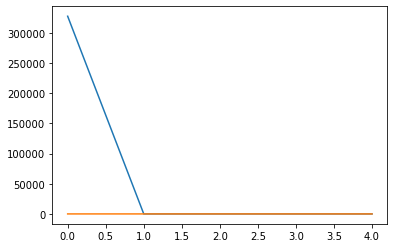

In [11]:
import matplotlib.pyplot as plt
history.history.keys()
epochs = [x for x in range(5)]
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])